In [1]:
#Libraries

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score

# modeling and evaluating
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

# Exploring
import scipy.stats as stats
import math

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

%matplotlib inline

# Add more libraries below this line as needed.

In [2]:
import os
import env
import acquire
import wrangle
import wrangle_zillow_new

credentials loaded successfully
End of file.
Loaded zillow wrangle functions successfully.
Imported prepare.py successfully


In [3]:
df = wrangle.get_zillow_data()
df.shape

(77381, 70)

In [4]:
df.head()

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,logerror,pid,tdate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1727539,NaN,...,0.025595,14297519,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1387261,NaN,...,0.055619,17052889,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,NaN,NaN,261.0,NaN,NaN,NaN,NaN,11677,NaN,...,0.005383,14186244,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,NaN,NaN,261.0,2.0,NaN,NaN,NaN,2288172,NaN,...,-0.103410,12177905,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10887214,NaN,NaN,266.0,2.0,NaN,NaN,1.0,1970746,NaN,...,0.006940,10887214,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 70 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   propertylandusetypeid         77381 non-null  float64
 4   heatingorsystemtypeid         49440 non-null  float64
 5   buildingclasstypeid           15 non-null     float64
 6   architecturalstyletypeid      206 non-null    float64
 7   airconditioningtypeid         24953 non-null  float64
 8   id                            77381 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77381 non-null  float64
 11  bedroomcnt                    77381 non-null  float64
 12  buildingqualitytypeid         49672 non-null  float64
 13  c

In [6]:
df.propertylandusetypeid.value_counts()

261.0    52320
266.0    19294
246.0     2009
269.0     1944
248.0      727
247.0      535
265.0      333
263.0       74
275.0       58
260.0       37
267.0       29
31.0        15
264.0        6
Name: propertylandusetypeid, dtype: int64

In [7]:
df['propertycountylandusecode'] = df['propertycountylandusecode'].astype(int)

ValueError: invalid literal for int() with base 10: '010C'

### First step, remove columns that I know I won't be needing

In [8]:
df.isna().sum().sort_values()

parcelid                         0
latitude                         0
logerror                         0
longitude                        0
propertycountylandusecode        0
                             ...  
basementsqft                 77331
storytypeid                  77331
finishedsquarefeet13         77340
buildingclasstypeid          77366
buildingclassdesc            77366
Length: 70, dtype: int64

A lot of missing values, however I will remove the columns I don't think I'll be needing first, then address missing rows.

In [9]:
# Dropping columns I don't think I'll need. If I do end up needing them, come back to this point after the MVP is done.

df = wrangle.drop_cols(df)
df.shape

(77381, 56)

In [10]:
# I need to isolate down to only single unit properties, which equate to this list:

id_list = [261.0, 260.0, 262.0, 263.0, 264.0]

In [11]:
# Now I have 20k less rows, so good for the most part. Now need to cut down the columns:

df = wrangle.prep_data(df, id_list)
df.shape

(52244, 56)

In [15]:
# Now, drop the list code now that I don't need it:
df = df.drop(columns = ['propertycountylandusecode'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52244 entries, 0 to 77380
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52244 non-null  int64  
 1   propertylandusetypeid         52244 non-null  float64
 2   bathroomcnt                   52244 non-null  float64
 3   bedroomcnt                    52244 non-null  float64
 4   calculatedfinishedsquarefeet  52236 non-null  float64
 5   fips                          52244 non-null  float64
 6   fullbathcnt                   52228 non-null  float64
 7   latitude                      52244 non-null  float64
 8   longitude                     52244 non-null  float64
 9   lotsizesquarefeet             51883 non-null  float64
 10  rawcensustractandblock        52244 non-null  float64
 11  regionidcity                  51216 non-null  float64
 12  regionidcounty                52244 non-null  float64
 13  r

In [16]:
df = wrangle.handle_missing_values(df, col_limit = .6, row_limit = .6)
df.shape

(52244, 21)

In [17]:
df.head(2)

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror
0,14297519,261.0,3.5,4.0,3100.0,6059.0,3.0,33.634931,-117.869207,4506.0,...,53571.0,1286.0,0.0,1.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595
1,17052889,261.0,1.0,2.0,1465.0,6111.0,1.0,34.449266,-119.281531,12647.0,...,13091.0,2061.0,5.0,1.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619


In [18]:
df.isna().sum().sort_values(ascending = False)

regionidcity                    1028
lotsizesquarefeet                361
structuretaxvaluedollarcnt        72
yearbuilt                         40
fullbathcnt                       16
calculatedfinishedsquarefeet       8
taxamount                          4
landtaxvaluedollarcnt              1
taxvaluedollarcnt                  1
logerror                           0
propertylandusetypeid              0
bathroomcnt                        0
bedroomcnt                         0
fips                               0
rawcensustractandblock             0
latitude                           0
longitude                          0
regionidcounty                     0
roomcnt                            0
unitcnt                            0
parcelid                           0
dtype: int64

## Things on my mind:

- Will clustering be beneficial to my understanding of the data and relationships
- Are there new features I can create from my current feature list that will do a better job of predicting `logerror`?

In [19]:
pd.set_option('display.max_columns', 40)

# Adding new dummy columns:

county_df = pd.get_dummies(df.fips)
county_df.head(1)

county_df.columns = ["LA", "Orange", "Ventura"]
# df_dummies = pd.concat([df, county_df], axis = 1)
df = pd.concat([df, county_df], axis = 1)
print(df.shape)
df.head(1)

(52244, 24)


,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura
0,14297519,261.0,3.5,4.0,3100.0,6059.0,3.0,33.634931,-117.869207,4506.0,6.059063e+07,53571.0,1286.0,0.0,1.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,0,1,0


In [20]:
# adding features:

def create_features(df):
    df['age'] = 2017 - df.yearbuilt

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt
    
    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560
    
    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet

    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
    
    # ratio of beds to baths
    df['bed_bath_ratio'] = df.bedroomcnt/df.bathroomcnt
    
#     # 12447 is the ID for city of LA. 
#     # I confirmed through sampling and plotting, as well as looking up a few addresses.
#     df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)
    
    return df

In [21]:
df = create_features(df)

<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='fips'>

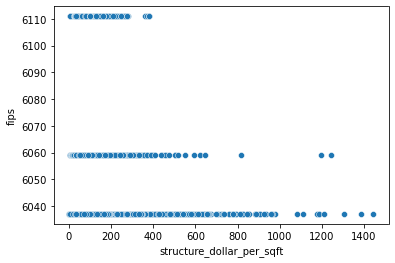

In [22]:
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'fips', data = df)

# Note there are only about 8 outliers that are making the 4th quartile to the max value extremely large compared to the rest of the quartiles.
# These kind of outliers will greatly affect the clustering models. Need to remove them.

In [23]:
# Need to remove outliers because outliers have a very large negative impact on clustering.

def remove_outliers():
    '''
    remove outliers in in structure dollars and land dollars.
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) &  
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.acres < 10) &
               (df.calculatedfinishedsquarefeet < 7000) & 
               (df.taxrate < .05) &
               (df.structure_dollar_per_sqft < 1001) &
               (df.land_dollar_per_sqft < 1501)
              )]

<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='fips'>

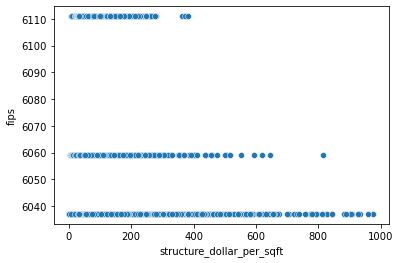

In [24]:
df = remove_outliers()
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'fips', data = df)

<AxesSubplot:xlabel='land_dollar_per_sqft', ylabel='structure_dollar_per_sqft'>

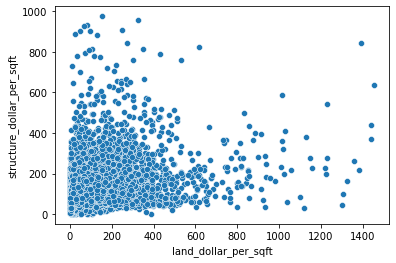

In [25]:
sns.scatterplot(x = 'land_dollar_per_sqft', y = 'structure_dollar_per_sqft', data = df)

In [26]:
df.isnull().sum().sort_values(ascending = False)

regionidcity                    970
yearbuilt                        32
age                              32
fullbathcnt                      15
unitcnt                           0
propertylandusetypeid             0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet      0
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet                 0
rawcensustractandblock            0
regionidcounty                    0
roomcnt                           0
cola                              0
bed_bath_ratio                    0
structuretaxvaluedollarcnt        0
taxvaluedollarcnt                 0
landtaxvaluedollarcnt             0
taxamount                         0
logerror                          0
LA                                0
Orange                            0
Ventura                           0
taxrate                           0
acres                       

In [27]:
df_la = df[df.LA == 1].drop(columns = ['Orange', 'Ventura'])
df_la.shape

(33160, 29)

In [28]:
df_o = df[df.Orange == 1].drop(columns = ['LA', 'Ventura'])
df_v = df[df.Ventura == 1].drop(columns = ['Orange', 'LA'])
df_o.shape, df_v.shape

((13939, 29), (4338, 29))

In [29]:
df_la.head(1)

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
3,12177905,261.0,3.0,4.0,2376.0,6037.0,3.0,34.24518,-118.240722,13038.0,6.037300e+07,396551.0,3101.0,0.0,1.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.10341,1,47.0,0.012247,0.299311,45.840909,2.778417,1.333333,0


In [30]:
# Checking to see the count of fips in each new county df. Making sure there wasn't any leakage between them.

df_la.fips.value_counts(), df_o.fips.value_counts(), df_v.fips.value_counts(),

(6037.0    33160
 Name: fips, dtype: int64,
 6059.0    13939
 Name: fips, dtype: int64,
 6111.0    4338
 Name: fips, dtype: int64)

At this point, I'd want to do everything in triplets, but I think that'll take too long so I'm going to continue using the main dataframe and just add a county column so that I can still divide things by county.

I'll end up with 3 dataframes per county df, which means a total of 9 dataframes... That seems like a bit much, at least for an MVP.

In [31]:
df.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
0,14297519,261.0,3.5,4.0,3100.0,6059.0,3.0,33.634931,-117.869207,4506.0,6.059063e+07,53571.0,1286.0,0.0,1.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,0,1,0,19.0,0.010763,0.103444,156.681613,119.300710,1.142857,0
1,17052889,261.0,1.0,2.0,1465.0,6111.0,1.0,34.449266,-119.281531,12647.0,6.111001e+07,13091.0,2061.0,5.0,1.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,0,0,1,50.0,0.012225,0.290335,60.068259,29.730371,2.000000,0
2,14186244,261.0,2.0,3.0,1243.0,6059.0,2.0,33.886168,-117.823170,8432.0,6.059022e+07,21412.0,1286.0,6.0,1.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,0,1,0,55.0,0.011488,0.193572,68.615447,56.865394,1.500000,0
3,12177905,261.0,3.0,4.0,2376.0,6037.0,3.0,34.245180,-118.240722,13038.0,6.037300e+07,396551.0,3101.0,0.0,1.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,1,0,0,47.0,0.012247,0.299311,45.840909,2.778417,1.333333,0
6,12095076,261.0,3.0,4.0,2962.0,6037.0,3.0,34.145202,-118.179824,63000.0,6.037461e+07,47019.0,3101.0,0.0,1.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,1,0,0,67.0,0.012306,1.446281,93.411209,7.882841,1.333333,0


## Splitting Data

In [32]:
train, validate, test = wrangle.split_zillow_data(df)

Shape of train df: (34976, 31)
Shape of validate df: (8745, 31)
Shape of test df: (7716, 31)


In [33]:
# Impute missing values
train.isna().sum().sort_values(ascending = False)

regionidcity                    658
yearbuilt                        19
age                              19
fullbathcnt                      12
unitcnt                           0
propertylandusetypeid             0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet      0
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet                 0
rawcensustractandblock            0
regionidcounty                    0
roomcnt                           0
cola                              0
bed_bath_ratio                    0
structuretaxvaluedollarcnt        0
taxvaluedollarcnt                 0
landtaxvaluedollarcnt             0
taxamount                         0
logerror                          0
LA                                0
Orange                            0
Ventura                           0
taxrate                           0
acres                       

In [63]:
# now filling the in the missing values, only on train.

train, validate, test = wrangle.impute_missing_values_all(train, validate, test)
train.head()

# Don't forget to .cut() in this area
# bin by age of house, county, tax bracket, and sq footage for starters

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
55013,12492265,261.0,1.0,3.0,1138.0,6037.0,1.0,33.834048,-118.109644,5151.0,6.037571e+07,12292.0,3101.0,0.0,1.0,1950.0,114320.0,444697.0,330377.0,5476.30,-0.072515,1,0,0,67.0,0.012315,0.118251,100.456942,64.138420,3.000000,0
58574,13860682,261.0,4.5,5.0,4938.0,6059.0,4.0,33.681750,-118.023703,7000.0,6.059099e+07,25218.0,1286.0,0.0,1.0,2006.0,806077.0,1213465.0,407388.0,13550.28,0.004192,0,1,0,11.0,0.011167,0.160698,163.239571,58.198286,1.111111,0
42273,12647836,261.0,2.0,2.0,1900.0,6037.0,2.0,34.060655,-118.259903,3175.0,6.037208e+07,12447.0,3101.0,0.0,1.0,1979.0,323194.0,512488.0,189294.0,6160.52,0.004195,1,0,0,38.0,0.012021,0.072888,170.102105,59.620157,1.000000,1
61964,14406077,261.0,2.0,3.0,1685.0,6059.0,2.0,33.510960,-117.664477,4120.0,6.059042e+07,33840.0,1286.0,7.0,1.0,1973.0,120807.0,257959.0,137152.0,2647.94,-0.009832,0,1,0,44.0,0.010265,0.094582,71.695549,33.289320,1.500000,0
31228,10974999,261.0,3.0,3.0,1789.0,6037.0,3.0,34.303344,-118.433433,6976.0,6.037106e+07,47547.0,3101.0,0.0,1.0,1947.0,97342.0,172063.0,74721.0,2132.26,0.043437,1,0,0,70.0,0.012392,0.160147,54.411403,10.711153,1.000000,0


In [64]:
# Missing values appear to be taken care of...

train.isnull().sum()

parcelid                        0
propertylandusetypeid           0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
land_dollar_per_sqft            0
bed_bath_ratio

In [77]:
def split_new(train, validate, test, target_var):
#     # split df into train_validate (80%) and test (20%)
#     train_validate, test = train_test_split(df, test_size=.20, random_state=13)
#     # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
#     train, validate = train_test_split(train_validate, test_size=.3, random_state=13)
    
    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [79]:
X_train, y_train, X_validate, y_validate, X_test, y_test = split_new(train, validate, test, 'logerror')

In [80]:
X_train.isnull().sum()

parcelid                        0
propertylandusetypeid           0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
land_dollar_per_sqft            0
bed_bath_ratio                  0
cola          

In [81]:
def scale_min_max():
    # create the scaler object and fit to X_train (get the min and max from X_train for each column)
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)

    # transform X_train values to their scaled equivalent and create df of the scaled features
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                                  columns=X_train.columns.values).set_index([X_train.index.values])
    
    # transform X_validate values to their scaled equivalent and create df of the scaled features
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate),
                                    columns=X_validate.columns.values).set_index([X_validate.index.values])

    # transform X_test values to their scaled equivalent and create df of the scaled features   
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                                 columns=X_test.columns.values).set_index([X_test.index.values])
    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [82]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_min_max()

In [83]:
X_train_scaled.isnull().sum()

parcelid                        0
propertylandusetypeid           0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
land_dollar_per_sqft            0
bed_bath_ratio                  0
cola          

## End of prep:

- All missing values accounted for
- All columns still in dataframe are ones I need for analysis
- Data not yet scaled, need to accomplish this before moving on with rest of Explore stage

## *Outliers still need to be dealt with after the MVP is complete*

# Explore Stage

- Based on Faith's advice for the MVP, I will be exploring based upon unscaled train, validate, and test data.
- However, when it comes time to model, I'll need to scale the data. I would prefer to have that step completed at end of prep, so will add scaling section here
### y_train ==  `logerror`

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='logerror'>

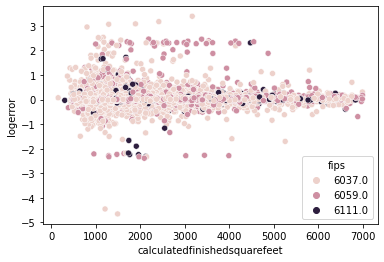

In [84]:
# For a simple visual answer, I'm going to use a scatterplot, with logerror being the value.

sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'logerror', data = train, hue = 'fips')

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

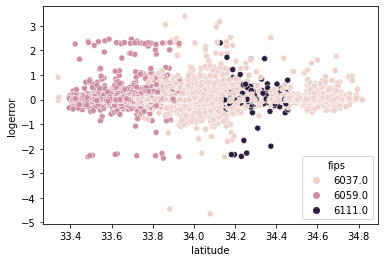

In [85]:
sns.scatterplot(x = 'latitude', y = 'logerror', data = train, hue = 'fips')

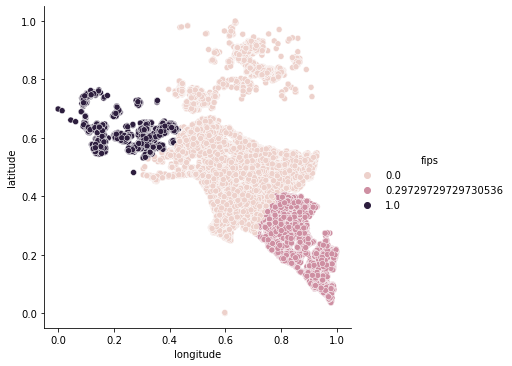

In [86]:
sns.relplot(x="longitude", y="latitude", hue="fips", data=train_scaled)

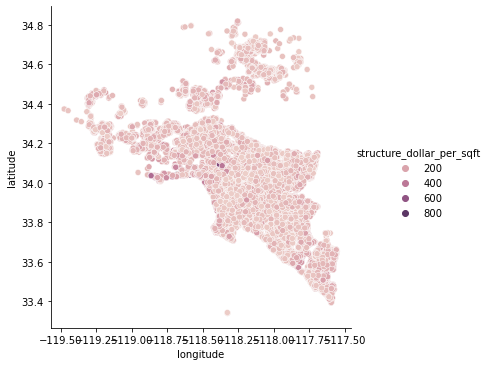

In [87]:
sns.relplot(x="longitude", y="latitude", hue="structure_dollar_per_sqft", data=train)

In [88]:
# Are there any features that I want to create from the existing data? Any I want to take away?
# First let's check the distributions of the existing cleaned columns:

## Can I visualize any significant relationship between logerror and any of my current features?

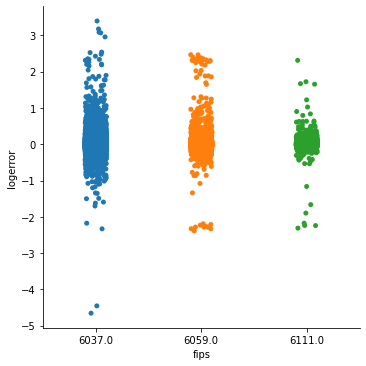

In [89]:
# I'm not seeing any... And if I can't find any, not sure what to test or model on...

sns.catplot(x = 'fips', y = 'logerror', data = train)

In [90]:
# What should I bit? How effective would that be? Let's run histograms to see what the distributions are:

In [91]:
df.age.isnull().sum()

32

In [93]:
area_vars = ['latitude', 'longitude', 'age']

def elbow_plot(cluster_vars):
    # elbow method to identify good k for us
    ks = range(2,20)
    
    # empty list to hold inertia (sum of squares)
    sse = []

    # loop through each k, fit kmeans, get inertia
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train_scaled[cluster_vars])
        # inertia
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    # plot k with inertia
    plt.plot(ks, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow method to find optimal k')
    plt.show()

In [94]:
X_train_scaled.isnull().sum()

parcelid                        0
propertylandusetypeid           0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
LA                              0
Orange                          0
Ventura                         0
age                             0
taxrate                         0
acres                           0
structure_dollar_per_sqft       0
land_dollar_per_sqft            0
bed_bath_ratio                  0
cola          

     k          sse
0    2  2083.612519
1    3  1412.337827
2    4  1104.226898
3    5   903.374723
4    6   772.848258
5    7   687.370736
6    8   609.236256
7    9   546.123583
8   10   490.061433
9   11   461.347117
10  12   433.437671
11  13   407.587273
12  14   387.517287
13  15   358.775469
14  16   340.490143
15  17   324.661528
16  18   309.902595
17  19   293.828682


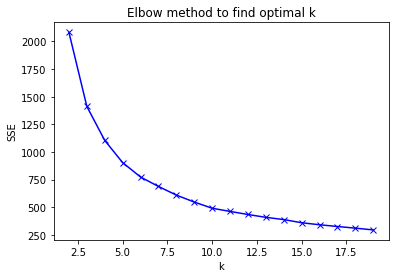

In [95]:
elbow_plot(cluster_vars = area_vars)

### Questions:

- Do I need to bin anything?
- What is the average tax rate per county?
- combine tax amount and square feet by county and compare
- 

In [ ]:
# going to try all columns:

# Creating a dataframe for a more managable heatmap
# corr_eval_df = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 'age', 'taxrate', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio', 'county', 'logerror']]
corr_eval_df = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'longitude', 'regionidcity', 'age', 'taxrate', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'bed_bath_ratio', 'county', 'logerror']]

# Code for the heatmap itself:
corr = corr_eval_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Takeaways:
- Right now the highest correlation is `fullbathcnt` and `age`
- But none of these features actually are over the limit of .2 or -.2 to become remotely "significant"

In [ ]:
corr = test_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(500, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This correlation matrix usually provides some hints as to which features are statistically correlated to the target variable, ie `logerror` in this case...

Still, I need to take whatever the MOST significant features are and go with those... at least for the MVP

In [ ]:
sns.barplot(data = train, x = 'county', y = 'logerror')

In [ ]:
# So log error is higher in orange county...? Interesting.

# What types of houses are predominant in Orange county? Low priced, high priced, normal "family" priced homes?

# Is the model worse at predicting middle income type homes, and better at the outliers?



In [ ]:
train.info()

In [ ]:
def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))

df = pd.Series([get_inertia(k) for k in range(2, 13)]).plot()

plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

# Clustering

In [ ]:
from sklearn.cluster import KMeans

In [101]:

# Fit K-Means
X = train_scaled[["age", "structure_dollar_per_sqft"]]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.labels_
train_scaled.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola,cluster
55013,0.011694,0.25,0.000000,0.333333,0.144089,0.000000,0.000000,0.333711,0.711051,0.010743,0.006359,0.022391,1.0,0.0,0.0,0.521739,0.024694,0.038143,0.031135,0.041201,0.569307,1.0,0.0,0.0,0.478261,0.245806,0.010743,0.102904,0.044081,0.571429,0,1
58574,0.020682,0.25,0.583333,0.666667,0.699401,0.297297,0.500000,0.230662,0.755793,0.014996,0.297643,0.055276,0.0,0.0,0.0,0.927536,0.174313,0.106150,0.038443,0.102497,0.578836,0.0,1.0,0.0,0.072464,0.222714,0.014996,0.167242,0.039997,0.166667,0,3
42273,0.012716,0.25,0.166667,0.166667,0.255444,0.000000,0.166667,0.487040,0.632823,0.006198,0.001450,0.022785,1.0,0.0,0.0,0.731884,0.069871,0.044140,0.017748,0.046396,0.578837,1.0,0.0,0.0,0.268116,0.239896,0.006198,0.174274,0.040975,0.142857,1,0
61964,0.024264,0.25,0.166667,0.333333,0.224025,0.297297,0.166667,0.115101,0.942814,0.008372,0.296872,0.077211,0.0,0.5,0.0,0.688406,0.026097,0.021623,0.012801,0.019729,0.577094,0.0,1.0,0.0,0.311594,0.204579,0.008372,0.073431,0.022874,0.250000,0,4
31228,0.001728,0.25,0.333333,0.333333,0.239223,0.000000,0.333333,0.651250,0.542479,0.014941,0.000072,0.112083,1.0,0.0,0.0,0.500000,0.021022,0.014025,0.006877,0.015814,0.583712,1.0,0.0,0.0,0.500000,0.247368,0.014941,0.055718,0.007353,0.142857,0,1


In [102]:
sns.relplot(x="age", y="structure_dollar_per_sqft", hue="county", data=train_scaled)

ValueError: Could not interpret value `county` for parameter `hue`

In [103]:
train.structure_dollar_per_sqft.describe()

count    34976.000000
mean        89.857245
std         56.491486
min          0.039833
25%         54.789368
50%         81.779513
75%        112.881808
max        975.870007
Name: structure_dollar_per_sqft, dtype: float64

In [ ]:
train.land_dollar_per_sqft.describe()

In [104]:
X = train_scaled[['age', 'land_dollar_per_sqft']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(n_clusters=4)

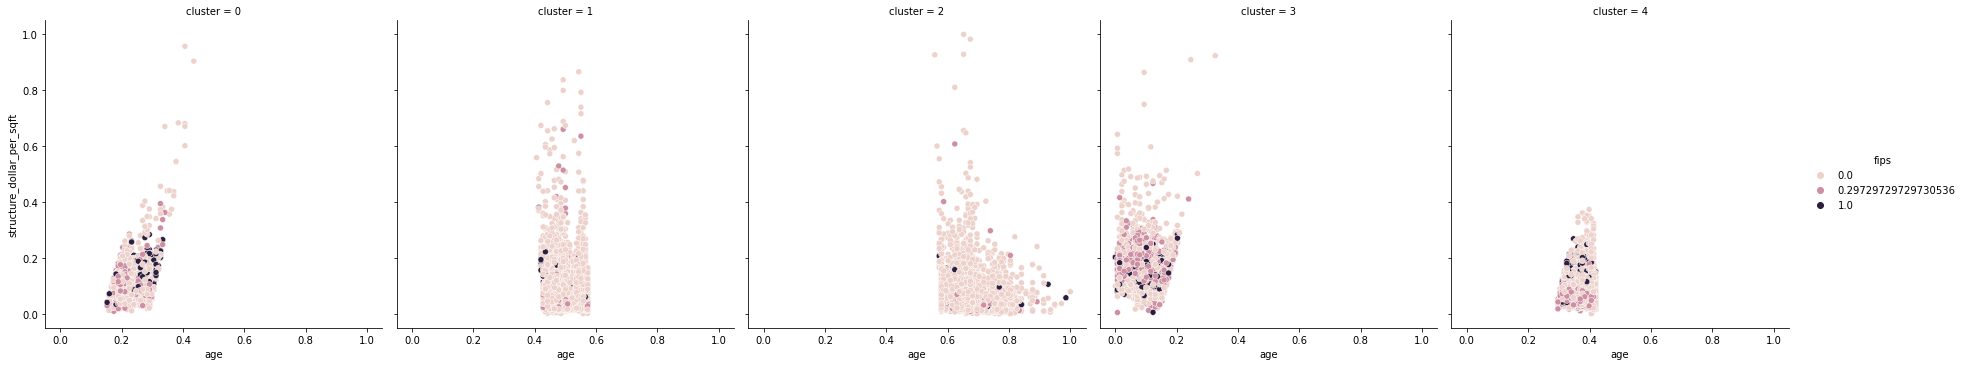

In [105]:

# visualize w/ hue="species" style="cluster"
sns.relplot(x="age", y="structure_dollar_per_sqft", hue="fips", col="cluster", data=train_scaled)

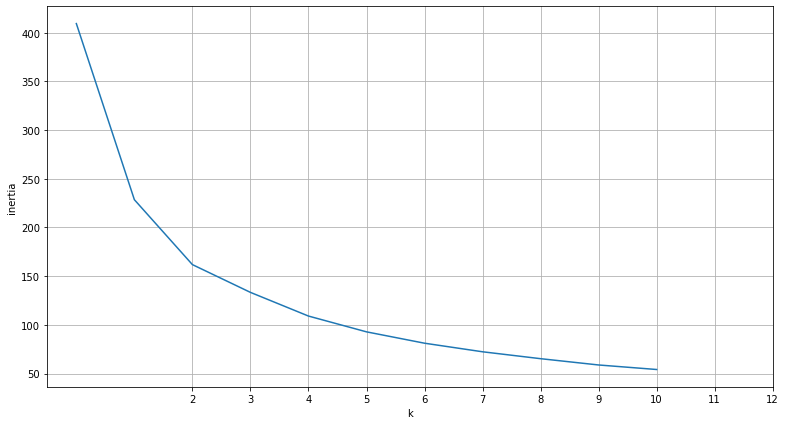

In [106]:
def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))

df = pd.Series([get_inertia(k) for k in range(2, 13)]).plot()

plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 13))
plt.grid()

In [ ]:
# It appears that the best number of centroids is around 5-6. So I'll try that again.

In [107]:
# Fit K-Means
X = X_train_scaled[["age", "structure_dollar_per_sqft"]]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.labels_
train_scaled.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola,cluster
55013,0.011694,0.25,0.000000,0.333333,0.144089,0.000000,0.000000,0.333711,0.711051,0.010743,0.006359,0.022391,1.0,0.0,0.0,0.521739,0.024694,0.038143,0.031135,0.041201,0.569307,1.0,0.0,0.0,0.478261,0.245806,0.010743,0.102904,0.044081,0.571429,0,1
58574,0.020682,0.25,0.583333,0.666667,0.699401,0.297297,0.500000,0.230662,0.755793,0.014996,0.297643,0.055276,0.0,0.0,0.0,0.927536,0.174313,0.106150,0.038443,0.102497,0.578836,0.0,1.0,0.0,0.072464,0.222714,0.014996,0.167242,0.039997,0.166667,0,5
42273,0.012716,0.25,0.166667,0.166667,0.255444,0.000000,0.166667,0.487040,0.632823,0.006198,0.001450,0.022785,1.0,0.0,0.0,0.731884,0.069871,0.044140,0.017748,0.046396,0.578837,1.0,0.0,0.0,0.268116,0.239896,0.006198,0.174274,0.040975,0.142857,1,0
61964,0.024264,0.25,0.166667,0.333333,0.224025,0.297297,0.166667,0.115101,0.942814,0.008372,0.296872,0.077211,0.0,0.5,0.0,0.688406,0.026097,0.021623,0.012801,0.019729,0.577094,0.0,1.0,0.0,0.311594,0.204579,0.008372,0.073431,0.022874,0.250000,0,2
31228,0.001728,0.25,0.333333,0.333333,0.239223,0.000000,0.333333,0.651250,0.542479,0.014941,0.000072,0.112083,1.0,0.0,0.0,0.500000,0.021022,0.014025,0.006877,0.015814,0.583712,1.0,0.0,0.0,0.500000,0.247368,0.014941,0.055718,0.007353,0.142857,0,1


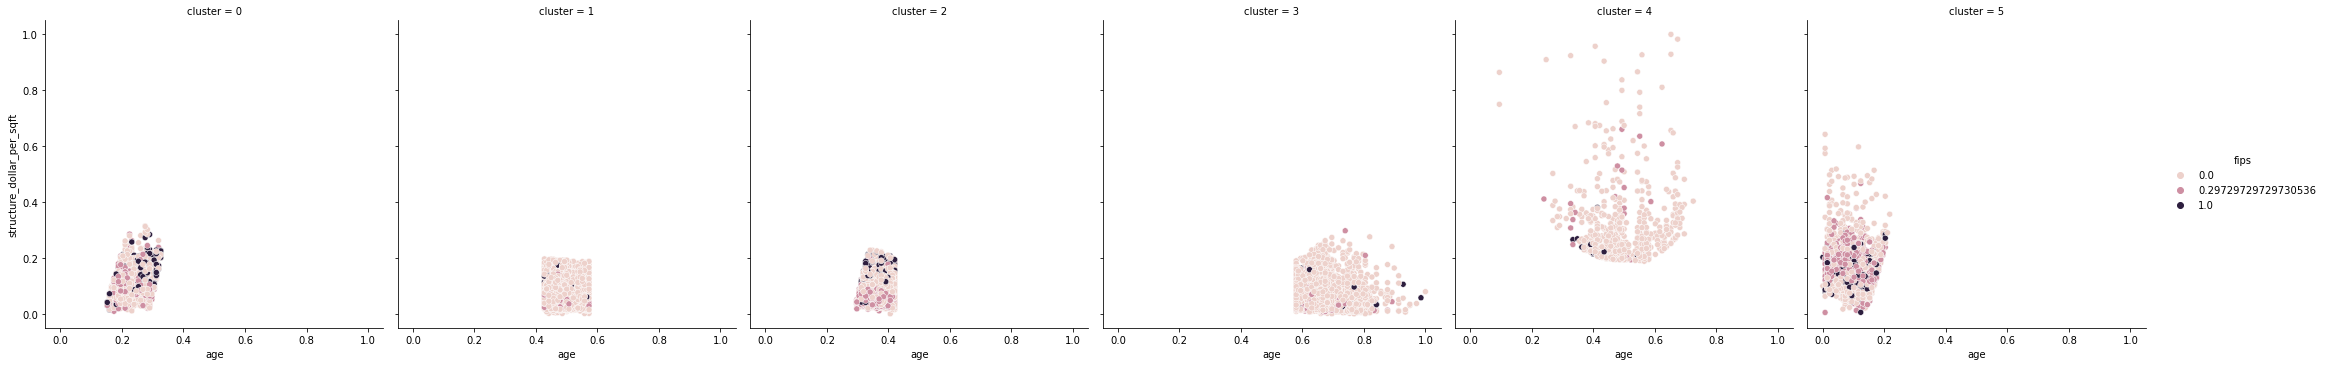

In [109]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="age", y="structure_dollar_per_sqft", hue="fips", col="cluster", data=train_scaled)

In [113]:
pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

,age,structure_dollar_per_sqft
0,0.239078,0.102184
1,0.476474,0.074228
2,0.370256,0.075593
3,0.674936,0.076139
4,0.492948,0.312528
5,0.104956,0.138162


In [116]:
X.shape, kmeans.labels_.shape

((34976, 2), (34976,))

In [118]:
train['cluster'] = kmeans.labels_

In [120]:
train.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola,cluster
55013,12492265,261.0,1.0,3.0,1138.0,6037.0,1.0,33.834048,-118.109644,5151.0,6.037571e+07,12292.0,3101.0,0.0,1.0,1950.0,114320.0,444697.0,330377.0,5476.30,-0.072515,1,0,0,67.0,0.012315,0.118251,100.456942,64.138420,3.000000,0,1
58574,13860682,261.0,4.5,5.0,4938.0,6059.0,4.0,33.681750,-118.023703,7000.0,6.059099e+07,25218.0,1286.0,0.0,1.0,2006.0,806077.0,1213465.0,407388.0,13550.28,0.004192,0,1,0,11.0,0.011167,0.160698,163.239571,58.198286,1.111111,0,5
42273,12647836,261.0,2.0,2.0,1900.0,6037.0,2.0,34.060655,-118.259903,3175.0,6.037208e+07,12447.0,3101.0,0.0,1.0,1979.0,323194.0,512488.0,189294.0,6160.52,0.004195,1,0,0,38.0,0.012021,0.072888,170.102105,59.620157,1.000000,1,0
61964,14406077,261.0,2.0,3.0,1685.0,6059.0,2.0,33.510960,-117.664477,4120.0,6.059042e+07,33840.0,1286.0,7.0,1.0,1973.0,120807.0,257959.0,137152.0,2647.94,-0.009832,0,1,0,44.0,0.010265,0.094582,71.695549,33.289320,1.500000,0,2
31228,10974999,261.0,3.0,3.0,1789.0,6037.0,3.0,34.303344,-118.433433,6976.0,6.037106e+07,47547.0,3101.0,0.0,1.0,1947.0,97342.0,172063.0,74721.0,2132.26,0.043437,1,0,0,70.0,0.012392,0.160147,54.411403,10.711153,1.000000,0,1


In [121]:
train.groupby('cluster').mean()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.349651e+07,261.007008,2.647001,3.454368,2181.526890,6055.765645,2.533409,34.059895,-118.128615,12091.206975,6.056087e+07,28237.309974,2258.599413,2.881356,1.000000,1983.013201,223976.649446,5.172298e+05,2.932532e+05,6096.138651,0.017651,0.476369,0.384289,0.139342,33.986799,0.012621,0.277576,99.762251,46.954449,1.350112,0.076434
1,1.229874e+07,260.999913,1.825751,2.969352,1479.643949,6041.387915,1.816461,34.030465,-118.221864,8417.804133,6.041748e+07,39632.371158,2859.047838,0.845893,1.000521,1950.247178,110431.830439,3.595751e+05,2.491433e+05,4510.961515,0.016430,0.856572,0.119726,0.023702,66.752822,0.013744,0.193246,72.423237,35.947780,1.813809,0.291196
2,1.349056e+07,261.000235,2.318262,3.530711,1849.067763,6055.071873,2.243688,33.967180,-118.183754,8965.725661,6.055297e+07,30345.986142,2224.532590,3.612801,1.000000,1964.895596,138497.195772,4.098536e+05,2.713564e+05,4922.713140,0.022501,0.465297,0.413388,0.121315,52.093247,0.012819,0.205825,73.808606,42.674806,1.587158,0.161245
3,1.223592e+07,260.999727,1.630292,2.735045,1486.596831,6040.019940,1.627697,34.025596,-118.246855,7086.373122,6.040346e+07,34323.957389,2968.069107,0.413002,1.001639,1922.858782,116027.585632,4.218015e+05,3.057739e+05,5207.908582,0.010306,0.916963,0.060093,0.022945,94.141218,0.013461,0.162681,74.338306,51.895211,1.888578,0.483748
4,1.194206e+07,260.998339,2.664452,3.112957,2182.478405,6039.966777,2.656146,34.044656,-118.379456,12261.107973,6.040320e+07,25037.416944,2999.272425,0.385382,1.001661,1947.981728,673046.539867,2.026624e+06,1.353578e+06,23906.789452,-0.013083,0.931894,0.039867,0.028239,69.018272,0.011871,0.281476,304.050905,159.136732,1.358302,0.544850
5,1.359605e+07,261.007262,3.343860,3.955106,2927.893266,6057.288292,3.161312,34.045987,-118.159433,11495.390185,6.057609e+07,28714.805898,2167.347931,1.436400,1.000000,2001.520026,419135.312720,9.055855e+05,4.864502e+05,11120.049388,0.023171,0.423195,0.430678,0.146127,15.479974,0.013261,0.263898,134.873137,73.640218,1.241310,0.063820


<AxesSubplot:xlabel='structure_dollar_per_sqft', ylabel='age'>

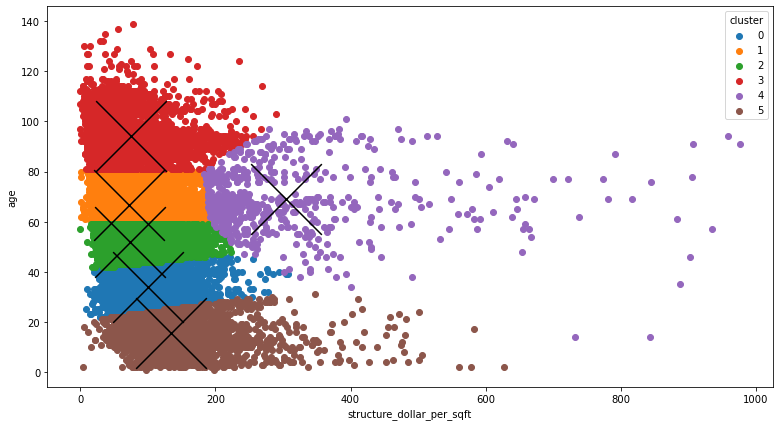

In [126]:
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train.groupby('cluster'):
    ax.scatter(subset.structure_dollar_per_sqft, subset.age, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='age', xlabel='struture value')

train.groupby('cluster').mean().plot.scatter(y='age', x='structure_dollar_per_sqft', marker='x', s=5000, ax=ax, c='black')

In [128]:
# Fit K-Means
X = X_train_scaled[["latitude", "longitude"]]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

X_train_scaled['cluster'] = kmeans.labels_
X_train_scaled.head()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola,cluster
55013,0.011694,0.25,0.000000,0.333333,0.144089,0.000000,0.000000,0.333711,0.711051,0.010743,0.006359,0.022391,1.0,0.0,0.0,0.521739,0.024694,0.038143,0.031135,0.041201,1.0,0.0,0.0,0.478261,0.245806,0.010743,0.102904,0.044081,0.571429,0.0,3
58574,0.020682,0.25,0.583333,0.666667,0.699401,0.297297,0.500000,0.230662,0.755793,0.014996,0.297643,0.055276,0.0,0.0,0.0,0.927536,0.174313,0.106150,0.038443,0.102497,0.0,1.0,0.0,0.072464,0.222714,0.014996,0.167242,0.039997,0.166667,0.0,4
42273,0.012716,0.25,0.166667,0.166667,0.255444,0.000000,0.166667,0.487040,0.632823,0.006198,0.001450,0.022785,1.0,0.0,0.0,0.731884,0.069871,0.044140,0.017748,0.046396,1.0,0.0,0.0,0.268116,0.239896,0.006198,0.174274,0.040975,0.142857,1.0,3
61964,0.024264,0.25,0.166667,0.333333,0.224025,0.297297,0.166667,0.115101,0.942814,0.008372,0.296872,0.077211,0.0,0.5,0.0,0.688406,0.026097,0.021623,0.012801,0.019729,0.0,1.0,0.0,0.311594,0.204579,0.008372,0.073431,0.022874,0.250000,0.0,4
31228,0.001728,0.25,0.333333,0.333333,0.239223,0.000000,0.333333,0.651250,0.542479,0.014941,0.000072,0.112083,1.0,0.0,0.0,0.500000,0.021022,0.014025,0.006877,0.015814,1.0,0.0,0.0,0.500000,0.247368,0.014941,0.055718,0.007353,0.142857,0.0,1


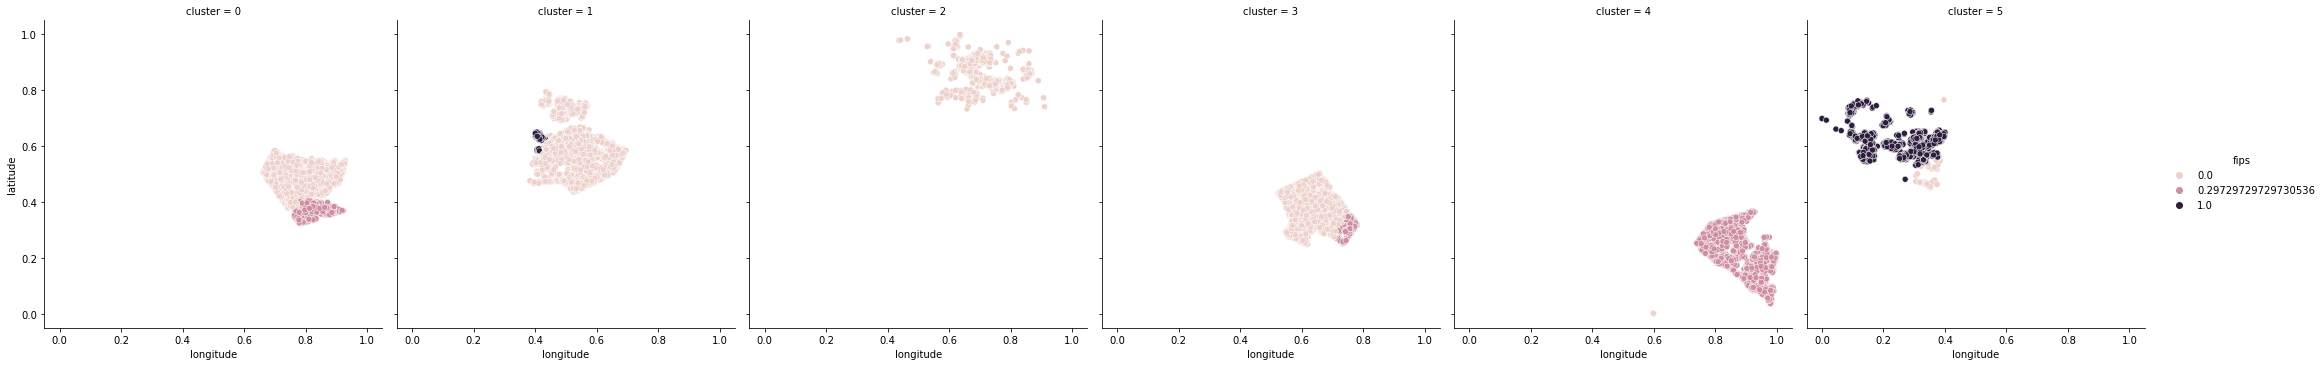

In [134]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="longitude", y="latitude", hue="fips", col="cluster", data=X_train_scaled)

#### This is actually very interesting... 

It seems like the clustering actually did a pretty decent job of clustering by location data... and incidentally, when I ran the correlation matrix, location information was the most correlated than the other features... still not significantly so, but more so than the other features.

In [131]:
pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

,latitude,longitude
0,0.457405,0.792906
1,0.578126,0.538422
2,0.870200,0.701238
3,0.362879,0.650815
4,0.219627,0.875593
5,0.608956,0.250284


In [132]:
X_train_scaled['cluster'] = kmeans.labels_
X_train_scaled.groupby('cluster').mean()

,parcelid,propertylandusetypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.015022,0.250144,0.192418,0.379635,0.236518,0.073100,0.185953,0.458376,0.792455,0.020090,0.076338,0.077271,0.754117,0.094027,0.000144,0.588353,0.033594,0.034289,0.023097,0.037665,0.754117,0.245883,0.000000,0.411642,0.271268,0.020090,0.082127,0.022262,0.289359,0.021815
1,0.004546,0.250119,0.234050,0.375670,0.269877,0.020831,0.233325,0.578041,0.538123,0.022645,0.023366,0.080518,0.988064,0.010696,0.000179,0.568735,0.049586,0.055948,0.039314,0.060115,0.979169,0.000000,0.020831,0.431261,0.254547,0.022645,0.107851,0.035152,0.253302,0.706106
2,0.003594,0.255875,0.224473,0.405389,0.250248,0.000000,0.224473,0.870200,0.701238,0.044018,0.010885,0.045796,1.000000,0.000000,0.000608,0.776205,0.032575,0.016505,0.004468,0.024664,1.000000,0.000000,0.000000,0.223795,0.348502,0.044018,0.081934,0.003515,0.263218,0.000000
3,0.011239,0.249966,0.148077,0.341054,0.205253,0.032536,0.144973,0.362599,0.651222,0.013397,0.037511,0.087356,0.890559,0.049273,0.000135,0.525526,0.028067,0.034530,0.025780,0.037589,0.890559,0.109441,0.000000,0.474455,0.275102,0.013397,0.078671,0.035564,0.316794,0.203440
4,0.023185,0.250000,0.262204,0.412890,0.295099,0.297169,0.228360,0.220031,0.875499,0.015501,0.296984,0.068435,0.000432,0.327394,0.000000,0.713698,0.047657,0.055514,0.039694,0.055079,0.000432,0.999568,0.000000,0.286302,0.236314,0.015501,0.091534,0.053124,0.237679,0.000000
5,0.042126,0.250877,0.245177,0.427335,0.285345,0.964925,0.220098,0.608942,0.250231,0.029040,0.965204,0.068021,0.447096,0.479381,0.000526,0.707296,0.052531,0.046882,0.028296,0.047077,0.035075,0.000000,0.964925,0.292539,0.234387,0.029040,0.114143,0.024100,0.260818,0.000000


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

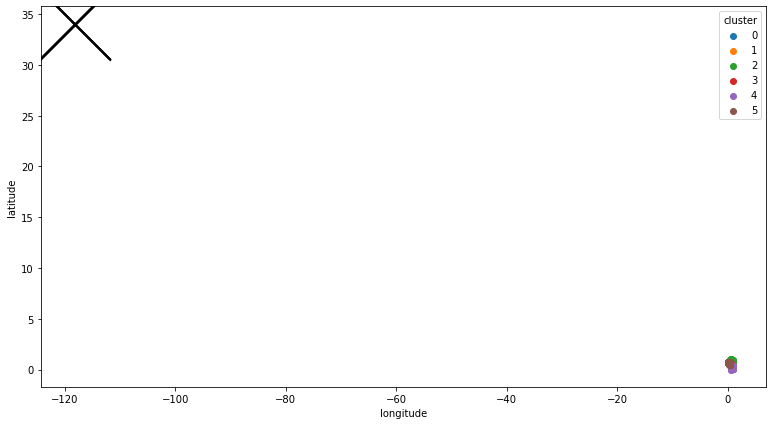

In [133]:
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in X_train_scaled.groupby('cluster'):
    ax.scatter(subset.longitude, subset.latitude, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='age', xlabel='struture value')

train.groupby('cluster').mean().plot.scatter(x='longitude', y='latitude', marker='x', s=5000, ax=ax, c='black')